Applying Gradient Boosting Models to forecast Power Demand. 

The aim of this script is to obtain a strong XGBOOST model, based on data prior to the beginning of the challenge. 
The resulting model will then be retrained/tuned with newer data as the challenge progresses.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import  mean_pinball_loss, d2_pinball_score, make_scorer

import requests
from datetime import datetime, date, timedelta
from tqdm import tqdm

import ephem

In [2]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)
    #ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    timestamps = list(response.json()["timestamps"])[4*52:]

 
    col_names = ['date_time','Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):

            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    #set date_time as index
    energydata.set_index("date_time", inplace=True)
    #resample
    energydata = energydata.resample("1h", label = "left").sum()

    return energydata

In [3]:
# Quantiles
alpha = np.array([.025, .25, .5, .75, .975])

# Create dataframe
df_raw = get_energy_data()
df_raw = df_raw.rename(columns={"Netzlast_Gesamt": "gesamt"})
df_raw['gesamt'] = df_raw['gesamt'] / 1000

  0%|          | 0/275 [00:00<?, ?it/s]C:\Users\Bilal\AppData\Local\Temp\ipykernel_13992\2279548712.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])
100%|██████████| 275/275 [00:40<00:00,  6.84it/s]


In [4]:
# Set start-, forecast-, and end-date here
start_dt = '2019-01-01 00:00:00'        # Data Availability starts here
forecast_dt = '2024-03-13 23:00:00'     # Wednesday/Thursday midnight
forecast_date = '2024-03-13' 
end_dt = '2023-11-15 23:00:00'          # Sunday midnight

In [5]:
# filter data
df = df_raw.copy()
df = df.loc[(df.index >= start_dt) & (df.index <= end_dt)]


In [6]:
holidays = pd.read_csv('C:\\Users\\Bilal\\Desktop\\ptsfc code\\seminar\\holidays.csv')
# holidays = np.array(holidays)
holidays.index = pd.to_datetime(holidays['x'])
holidays['date'] = holidays.index.date
holidays


,x,date
x,,
2018-01-01,2018-01-01,2018-01-01
2018-01-06,2018-01-06,2018-01-06
2018-03-30,2018-03-30,2018-03-30
2018-04-02,2018-04-02,2018-04-02
2018-05-01,2018-05-01,2018-05-01
...,...,...
2024-10-31,2024-10-31,2024-10-31
2024-11-01,2024-11-01,2024-11-01
2024-12-24,2024-12-24,2024-12-24


In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date'] = df.index.date # to join with daylight hours
    return df

In [8]:
def add_lags(df):                       # more lags? yesterday, last week, ...
    target_map = df['gesamt'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364, so we get this day last year on the same weekday
    # df['lag3'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    # df['lag4'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [9]:
# Define the observer location (latitude and longitude for Germany)
latitude = '51.1657'  # Latitude for Germany
longitude = '10.4515'  # Longitude for Germany

# Create an observer object
germany = ephem.Observer()
germany.lat = latitude
germany.lon = longitude

# Set the date for which you want to calculate sunrise time
start_date = df.index.min().date()      # begins at same day as df
end_date =  df.index.max().date()           # + timedelta(days=7)

# Dictionary to store daylight hours for each date
daylight_hours_dict = {}


current_date = start_date
while current_date <= end_date:
    # Set the observer's date
    germany.date = current_date

    # Compute the sunrise time
    sunrise = germany.next_rising(ephem.Sun())
    sunset = germany.next_setting(ephem.Sun())

    daylight_hours = (sunset - sunrise) * 24  # Convert from days to hours

    # Store daylight hours for current date in the dictionary
    daylight_hours_dict[current_date] = daylight_hours
    # Move to next dax
    current_date += timedelta(days=1)

# Print daylight hours for each date
for date, daylight_hours in daylight_hours_dict.items():
    print(f"{date}: Daylight: {daylight_hours:.2f} hours")

2019-01-01: Daylight: 8.00 hours
2019-01-02: Daylight: 8.02 hours
2019-01-03: Daylight: 8.04 hours
2019-01-04: Daylight: 8.06 hours
2019-01-05: Daylight: 8.09 hours
2019-01-06: Daylight: 8.11 hours
2019-01-07: Daylight: 8.14 hours
2019-01-08: Daylight: 8.17 hours
2019-01-09: Daylight: 8.20 hours
2019-01-10: Daylight: 8.23 hours
2019-01-11: Daylight: 8.26 hours
2019-01-12: Daylight: 8.30 hours
2019-01-13: Daylight: 8.33 hours
2019-01-14: Daylight: 8.37 hours
2019-01-15: Daylight: 8.41 hours
2019-01-16: Daylight: 8.45 hours
2019-01-17: Daylight: 8.49 hours
2019-01-18: Daylight: 8.53 hours
2019-01-19: Daylight: 8.57 hours
2019-01-20: Daylight: 8.62 hours
2019-01-21: Daylight: 8.66 hours
2019-01-22: Daylight: 8.71 hours
2019-01-23: Daylight: 8.75 hours
2019-01-24: Daylight: 8.80 hours
2019-01-25: Daylight: 8.85 hours
2019-01-26: Daylight: 8.90 hours
2019-01-27: Daylight: 8.95 hours
2019-01-28: Daylight: 9.00 hours
2019-01-29: Daylight: 9.06 hours
2019-01-30: Daylight: 9.11 hours
2019-01-31

In [10]:
# Convert daylight_hours_dict to a DataFrame for easier manipulation
daylight_df = pd.DataFrame.from_dict(daylight_hours_dict, orient='index', columns=['daylight']) 
daylight_df

,daylight
2019-01-01,7.999110
2019-01-02,8.018310
2019-01-03,8.039151
2019-01-04,8.061609
2019-01-05,8.085658
...,...
2023-11-11,9.157498
2023-11-12,9.104315
2023-11-13,9.051822
2023-11-14,9.000053


In [11]:
df = create_features(df)
df = pd.merge(df, daylight_df, left_on='date', right_index=True)

# Create a new column 'isHoliday' and initialize it with 0
df['isHoliday'] = 0

# Mark holidays as 1
df.loc[df['date'].isin(holidays['date']), 'isHoliday'] = 1


# Create a new column 'isSaturday' and initialize it with 0
df['isSaturday'] = 0

# Mark Sundays as 1
df.loc[df['dayofweek'] == 5, 'isSaturday'] = 1



df = df.loc[df.dayofweek.isin([4, 5])]
df = df.loc[df.hour.isin([12,16,20])]
df

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,daylight,isHoliday,isSaturday
date_time,,,,,,,,,,,,,
2019-01-04 12:00:00,70.26775,12,4,1,1,2019,4,4,1,2019-01-04,8.061609,0,0
2019-01-04 16:00:00,67.83425,16,4,1,1,2019,4,4,1,2019-01-04,8.061609,0,0
2019-01-04 20:00:00,63.34125,20,4,1,1,2019,4,4,1,2019-01-04,8.061609,0,0
2019-01-05 12:00:00,60.79125,12,5,1,1,2019,5,5,1,2019-01-05,8.085658,0,1
2019-01-05 16:00:00,59.05350,16,5,1,1,2019,5,5,1,2019-01-05,8.085658,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-10 16:00:00,63.48250,16,4,4,11,2023,314,10,45,2023-11-10,9.211342,0,0
2023-11-10 20:00:00,58.81625,20,4,4,11,2023,314,10,45,2023-11-10,9.211342,0,0
2023-11-11 12:00:00,55.04875,12,5,4,11,2023,315,11,45,2023-11-11,9.157498,0,1


In [12]:
df = add_lags(df)

In [25]:
df

,gesamt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date,daylight,isHoliday,isSaturday,lag1,lag2,lag3
date_time,,,,,,,,,,,,,,,,
2018-12-28 12:00:00,58.90900,12,4,4,12,2018,362,28,52,2018-12-28,7.939154,0,0,NaN,NaN,NaN
2018-12-28 16:00:00,58.55400,16,4,4,12,2018,362,28,52,2018-12-28,7.939154,0,0,NaN,NaN,NaN
2018-12-28 20:00:00,55.58925,20,4,4,12,2018,362,28,52,2018-12-28,7.939154,0,0,NaN,NaN,NaN
2018-12-29 12:00:00,56.84650,12,5,4,12,2018,363,29,52,2018-12-29,7.951578,0,1,NaN,NaN,NaN
2018-12-29 16:00:00,57.72725,16,5,4,12,2018,363,29,52,2018-12-29,7.951578,0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-10 16:00:00,63.48250,16,4,4,11,2023,314,10,45,2023-11-10,9.211342,0,0,60.92150,59.38925,61.59425
2023-11-10 20:00:00,58.81625,20,4,4,11,2023,314,10,45,2023-11-10,9.211342,0,0,57.75600,58.09525,57.67675
2023-11-11 12:00:00,55.04875,12,5,4,11,2023,315,11,45,2023-11-11,9.157498,0,1,55.58050,54.08725,53.61375


In [13]:
# FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
#             'lag1','lag2', 'lag3', 'daylight', 'isHoliday']      

FEATURES = ['hour', 'isSaturday', 'quarter', 'month', 'year',
             'lag1','lag2', 'lag3', 'daylight', 'isHoliday']  
                                        
TARGET = 'gesamt'

X = df[FEATURES]
y = df[TARGET]


Find best model

Time Series Cross Validation

In [27]:
len(df) 

1530

In [182]:
(len(df) - (72*365)) / (24*3)


42912

In [32]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tss = TimeSeriesSplit(n_splits =50, test_size= 3*2, max_train_size=3*2*52*2) 
df = df.sort_index()

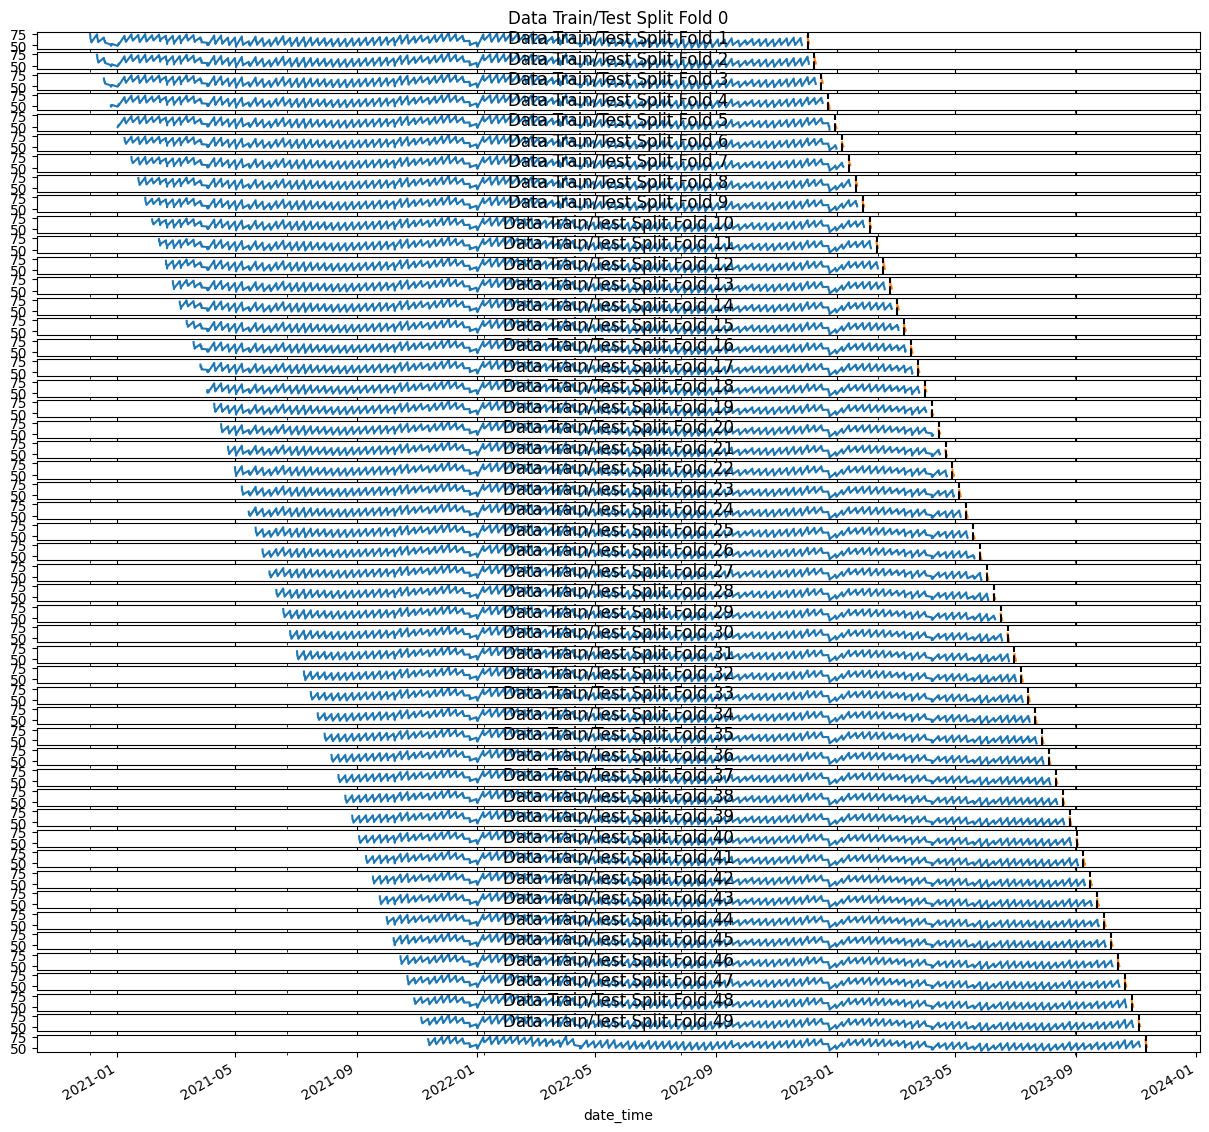

In [33]:
fig, axs = plt.subplots(50, 1, figsize=(15,15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['gesamt'].plot(ax=axs[fold],
                         label='Training Set',
                         title=f'Data Train/Test Split Fold {fold}')
    test['gesamt'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1
plt.show()

Tune Hyperparams for quantile regression

In [34]:


# Define the parameter grid to search
# more paramters?
# param_grid = {
#     'n_estimators': [200, 250, 500 ], # nbr trees
#     'max_depth': [1, 3, 5],
#     'learning_rate': [0.01, 0.05, 0.1]#,
#     #'early_stopping_rounds': [10, 50]
# }

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
    # 'subsample': [0.5, 0.7, 1],
    # 'colsample_bytree': [0.5, 0.7, 1],
    # 'lambda': [0, 1, 2],  # L2 regularization term
    # 'alpha': [0, 0.5, 1],  # L1 regularization term
    # 'min_child_weight': [1, 5, 10],
    # 'gamma': [0, 0.1, 0.2],
    # 'early_stopping_rounds': [50]  # You might want to adjust this based on your dataset
}

model_q1 = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha = 0.025,  booster = 'gbtree')
model_q2 = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha = 0.25,  booster = 'gbtree')
model_q3 = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha = 0.5,  booster = 'gbtree')
model_q4 = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha = 0.75,  booster = 'gbtree')
model_q5 = xgb.XGBRegressor(objective='reg:quantileerror', quantile_alpha = 0.9755,  booster = 'gbtree')
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=24*30)

In [35]:

# Define the pinball loss function for quantile regression
def mqloss(y_true, y_pred, alpha):  
  if (alpha > 0) and (alpha < 1):
    residual = y_true - y_pred 
    return np.mean(-2* residual * (alpha - (residual<0)))
  else:
    return np.nan

# Define the scorer using the pinball loss function
mqloss_scorer_q1 = make_scorer(mqloss, alpha=0.025)
mqloss_scorer_q2 = make_scorer(mqloss, alpha=0.25)
mqloss_scorer_q3 = make_scorer(mqloss, alpha=0.5)
mqloss_scorer_q4 = make_scorer(mqloss, alpha=0.75)
mqloss_scorer_q5 = make_scorer(mqloss, alpha=0.975)

In [36]:
gs_q1 = GridSearchCV(estimator=model_q1, param_grid=param_grid, scoring=mqloss_scorer_q1, cv=tss)
gs_q2 = GridSearchCV(estimator=model_q2, param_grid=param_grid, scoring=mqloss_scorer_q2, cv=tss)
gs_q3 = GridSearchCV(estimator=model_q3, param_grid=param_grid, scoring=mqloss_scorer_q3, cv=tss)
gs_q4 = GridSearchCV(estimator=model_q4, param_grid=param_grid, scoring=mqloss_scorer_q4, cv=tss)
gs_q5 = GridSearchCV(estimator=model_q5, param_grid=param_grid, scoring=mqloss_scorer_q5, cv=tss)


# to check if  scorer works correctly
# gs_q3 = GridSearchCV(
#         estimator=model_q3,
#         param_grid=param_grid,
#         scoring= 'neg_mean_absolute_error',
#         cv=tss  # 5-fold cross-validation
#     )




In [37]:
gs_q1.fit(X, y)

KeyboardInterrupt: 

In [ ]:
gs_q2.fit(X, y)

In [ ]:
gs_q3.fit(X, y)

In [ ]:
gs_q4.fit(X, y)

In [ ]:
gs_q5.fit(X, y)

In [65]:
print(gs_q3.best_estimator_)
print(gs_q3.best_params_)
print(gs_q3.best_score_)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='reg:quantileerror', ...)
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400}
-1.4023176238271926


In [66]:
gs_q3_results = pd.DataFrame(gs_q3.cv_results_)
gs_q3_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.349732,0.173054,0.012634,0.014498,0.01,1,100,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",-5.141696,-4.758215,-5.141352,-4.151809,-4.798268,0.404711,27
1,3.027976,0.058707,0.008589,0.001470,0.01,1,200,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",-3.744307,-3.396629,-3.900151,-2.913625,-3.488678,0.378753,24
2,6.548887,0.135219,0.006351,0.002499,0.01,1,400,"{'learning_rate': 0.01, 'max_depth': 1, 'n_est...",-2.421685,-2.086058,-2.760198,-2.295504,-2.390861,0.244621,22
3,1.178357,0.034092,0.004995,0.003353,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-4.303648,-3.928361,-4.246068,-3.357977,-3.959014,0.375286,26
4,2.171306,0.056500,0.007659,0.002623,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-2.461029,-2.122000,-2.689537,-2.324982,-2.399387,0.206438,23
5,4.633065,0.117446,0.009985,0.000627,0.01,3,400,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",-1.443865,-1.219060,-1.982564,-2.084298,-1.682447,0.361664,17
6,1.315830,0.034885,0.006538,0.003861,0.01,5,100,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-4.254906,-3.849316,-4.089618,-3.109875,-3.825929,0.437845,25
7,2.287817,0.051379,0.006930,0.003143,0.01,5,200,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-2.300769,-1.962881,-2.468301,-2.098402,-2.207588,0.192650,21
8,4.709578,0.152530,0.008075,0.004063,0.01,5,400,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",-1.352695,-1.148356,-1.814729,-1.982020,-1.574450,0.337112,14
9,1.744561,0.032442,0.005871,0.002999,0.05,1,100,"{'learning_rate': 0.05, 'max_depth': 1, 'n_est...",-2.040981,-1.747758,-2.515331,-2.222547,-2.131654,0.278867,20


In [56]:
gs_q3_results = gs_q3_results.sort_values("rank_test_score")
gs_q3_results.to_csv("gs_q3_alt_results.csv")

In [62]:
y_gercek = np.array([1, 4, 10])
y_sahte = np.array([2, 3, 14])

mqloss(y_true = y_gercek, y_pred = y_sahte, alpha = 0.25)

-2.6666666666666665